In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from scipy.fftpack import fft,ifft
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import adfuller, acf, pacf
import math
from scipy.fftpack import fft,ifft
from statsmodels.tsa.seasonal import seasonal_decompose
import time
# from pyecharts import Line
# from pyecharts import Grid
# from pyecharts import Timeline, Page, configure


def read_csv_day(year):
    string = "sum-"+str(year)+".csv"
    df = pd.read_csv(string)
    date = list()
    for i in range(len(df)):
        date.append(datetime.date(df["year"][i], df["month"][i], df["day"][i]))
    date = pd.to_datetime(date)
    df.index = date
    df_car = df["car"].astype(np.float64)
    df_truck = df["truck"].astype(np.float64)
    return df_car, df_truck


/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df_car_2009, df_truck_2009 = read_csv_day(2009)
df_car_2010, df_truck_2010 = read_csv_day(2010)
df_car_2011, df_truck_2011 = read_csv_day(2011)
df_car_2012, df_truck_2012 = read_csv_day(2012)
df_car_2013, df_truck_2013 = read_csv_day(2013)
df_car_2014, df_truck_2014 = read_csv_day(2014)
df_car_2015, df_truck_2015 = read_csv_day(2015)
df_car_2016, df_truck_2016 = read_csv_day(2016)
df_car_2017, df_truck_2017 = read_csv_day(2017)


# plt.figure(figsize=(12, 8))
# plt.plot(df_car_2012)
# plt.show()
# exit(1)

df_car_2009M = df_car_2009.resample('M').sum()
df_car_2010M = df_car_2010.resample('M').sum()
df_car_2011M = df_car_2011.resample('M').sum()
df_car_2012M = df_car_2012.resample('M').sum()
df_car_2013M = df_car_2013.resample('M').sum()
df_car_2014M = df_car_2014.resample('M').sum()
df_car_2015M = df_car_2015.resample('M').sum()
df_car_2016M = df_car_2016.resample('M').sum()
df_car_2017M = df_car_2017.resample('M').sum()

df_truck_2009M = df_truck_2009.resample('M').sum()
df_truck_2010M = df_truck_2010.resample('M').sum()
df_truck_2011M = df_truck_2011.resample('M').sum()
df_truck_2012M = df_truck_2012.resample('M').sum()
df_truck_2013M = df_truck_2013.resample('M').sum()
df_truck_2014M = df_truck_2014.resample('M').sum()
df_truck_2015M = df_truck_2015.resample('M').sum()
df_truck_2016M = df_truck_2016.resample('M').sum()
df_truck_2017M = df_truck_2017.resample('M').sum()

df_car_A = pd.concat([df_car_2009M, df_car_2010M, df_car_2011M, df_car_2012M, df_car_2013M,
                     df_car_2014M, df_car_2015M, df_car_2016M, df_car_2017M])
df_truck_A = pd.concat([df_truck_2009M, df_truck_2010M, df_truck_2011M, df_truck_2012M, 
                        df_truck_2013M, df_truck_2014M, df_truck_2015M])

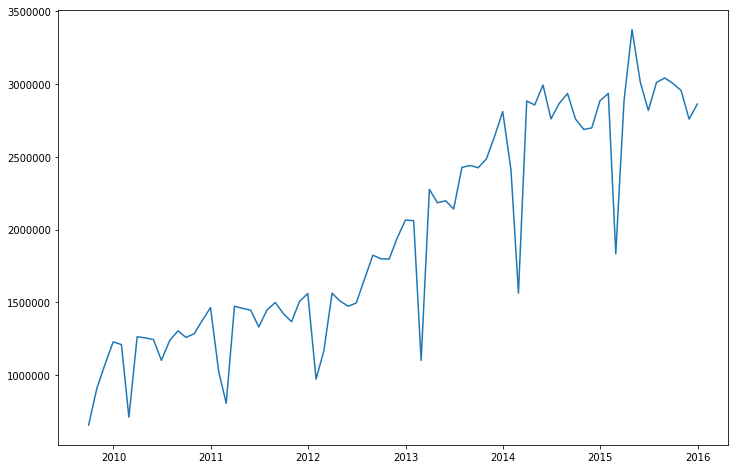

In [3]:
plt.figure(figsize = (12,8))
plt.plot(df_truck_A)
plt.show()

In [4]:
train = df_truck_A
#程序判断稳定性
def testStationarity(timeSer):

    stationarity = False

    dftest = adfuller(timeSer)
    dfoutput = pd.Series(dftest[:4], index=[
                      'Test Statistic', 'p-value', 'lags', 'nobs'])

    for key, value in dftest[4].items():
        dfoutput['Critical values (%s)' % key] = value

    if dfoutput['Test Statistic'] < dfoutput['Critical values (5%)']:
        if dfoutput['p-value'] < 0.1:
            stationarity = True

    return stationarity

#定阶函数
def p_q_choice(timeSer, nlags=40, alpha=.05):

    kwargs = {'nlags': nlags, 'alpha': alpha}
    acf_x, confint = acf(timeSer, **kwargs)
    acf_px, confint2 = pacf(timeSer, **kwargs)

    confint = confint - confint.mean(1)[:, None]
    confint2 = confint2 - confint2.mean(1)[:, None]

    for key1, x, y, z in zip(range(nlags), acf_x, confint[:,0], confint[:,1]):
        if x > y and x < z: #选出第一个收敛于2倍标准差的值
            q = key1
            break

    for key2, x, y, z in zip(range(nlags), acf_px, confint2[:,0], confint[:,1]):
        if x > y and x < z:
            p = key2
            break

    return p, q

#确定几阶差分后平稳
def d_choice(timeSer):
    d=0
    while(1):
        flag = testStationarity(timeSer)
        if flag==True:
            break
        else:
            timeSer = timeSer.diff(1)
            d +=1
            timeSer = timeSer.dropna(how=any)
    return d

d= 2
p:  1  q:  1


/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


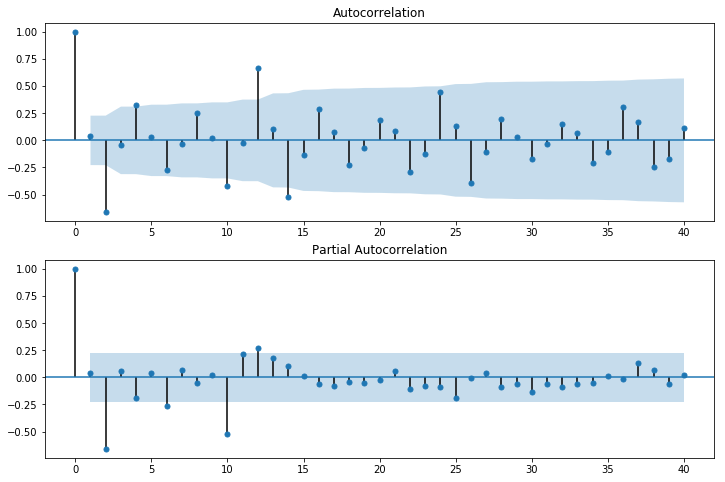

In [7]:
d = d_choice(train)
print("d=", d)
#观察自相关系数ACF和偏自相关系数PACF 
fig = plt.figure(figsize=(12,8)) 
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train.diff(d).dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train.diff(d).dropna(),lags=40,ax=ax2)

p,q = p_q_choice(train.diff(d).dropna())
print("p: ",p," q: ",q)

In [14]:
arma_mod1 = sm.tsa.ARIMA(train,(1,1,0))
arma_mod2 = sm.tsa.ARIMA(train,(0,1,1))
arma_mod3 = sm.tsa.ARIMA(train,order = (0,2,1))
arma_mod4 = sm.tsa.ARIMA(train,(2,2,0))
print("1:",arma_mod1.fit().aic,arma_mod1.fit().bic,arma_mod1.fit().hqic)
print("2:",arma_mod2.fit().aic,arma_mod2.fit().bic,arma_mod2.fit().hqic)
print("3:",arma_mod3.fit().aic,arma_mod3.fit().bic,arma_mod3.fit().hqic)
print("4:",arma_mod4.fit().aic,arma_mod4.fit().bic,arma_mod4.fit().hqic)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


1: 2131.7814399659032 2138.733904306512 2134.557482633576
2: 2107.4105573864035 2114.371778716831 2110.1866000540763
3: 2117.5291120006013 2124.441307280214 2120.2864716803865
4: 2144.551703946726 2153.7679643195424 2148.2281835197728


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


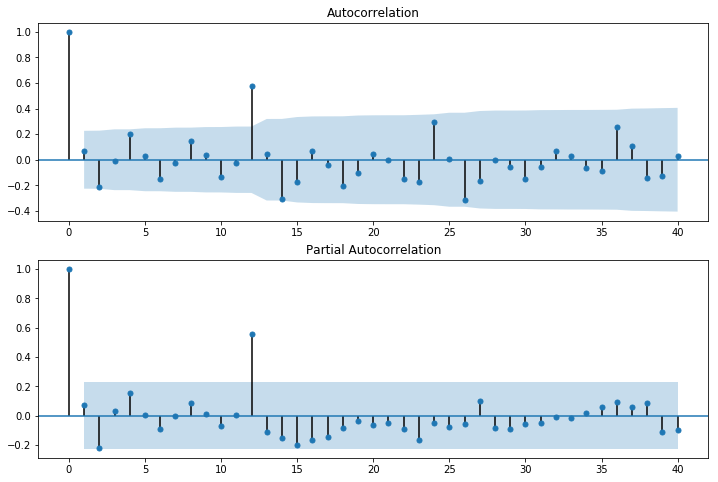

D-W检验:  1.841514258534474
            AC           Q      Prob(>Q)
lag                                     
1.0   0.072004    0.404606  5.247200e-01
2.0  -0.216949    4.128059  1.269415e-01
3.0  -0.006600    4.131552  2.476048e-01
4.0   0.198565    7.338541  1.190434e-01
5.0   0.029208    7.408923  1.919607e-01
6.0  -0.150240    9.298114  1.574934e-01
7.0  -0.024108    9.347472  2.286621e-01
8.0   0.148752   11.254698  1.876811e-01
9.0   0.036044   11.368377  2.513011e-01
10.0 -0.135810   13.007098  2.232753e-01
11.0 -0.027986   13.077773  2.882726e-01
12.0  0.578872   43.794630  1.655183e-05
13.0  0.042254   43.960931  3.115002e-05
14.0 -0.306674   52.864738  2.005949e-06
15.0 -0.176976   55.879325  1.269942e-06
16.0  0.068224   56.334919  2.142276e-06
17.0 -0.039324   56.488890  3.942113e-06
18.0 -0.205630   60.772897  1.533767e-06
19.0 -0.103941   61.887024  1.939010e-06
20.0  0.046291   62.112028  3.338736e-06
21.0 -0.002167   62.112531  6.084919e-06
22.0 -0.151322   64.607599  4.5

In [15]:
arma_fit = arma_mod2.fit(disp=0)
#检验残差序列
res = arma_fit.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(res, lags=40, ax=ax1) #.values.squeeze()
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(res, lags=40, ax=ax2)
plt.show()
# D-W检验
print('D-W检验: ',sm.stats.durbin_watson(res.values)) #接近0则正相关，接近4则负相关，接近2则不存在（一阶）自相关性

# Ljung-Box检验
# 判断其是否是高斯白噪声，如果不是，那么就说明ARIMA模型也许并不是一个适合样本的模型。
r,q,p = sm.tsa.acf(res.values.squeeze(), qstat=True)
dat = np.c_[range(1,41), r[1:], q, p]
table = pd.DataFrame(dat, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table.set_index('lag'))

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


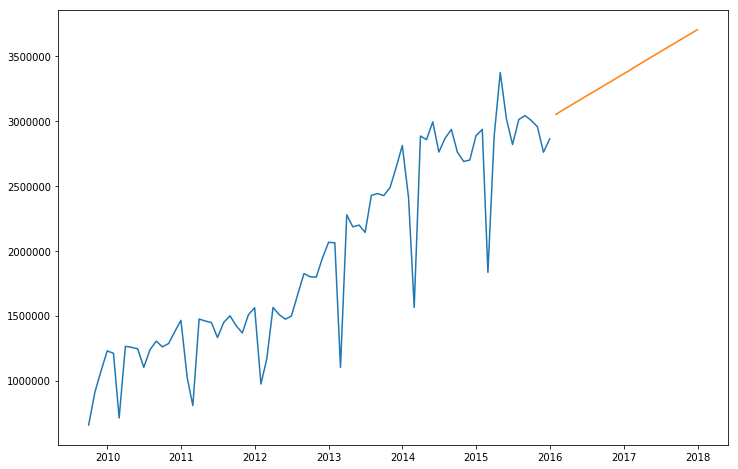

error: 0.15024206922529348
rmse: 578276.1740175206


In [18]:
#预测

predict_dta = arma_fit.predict('2016-01-31', '2017-12-31', typ='levels') #, typ='levels'
# print(predict_dta)

fig, ax = plt.subplots(figsize=(12, 8))
# ax = train.ix['2010-02-28':].plot(ax=ax)
# fig = arma_fit.plot_predict('2016-01-31', '2017-12-31', dynamic=True, ax=ax, plot_insample=False)
plt.plot(train)
plt.plot(predict_dta)
plt.show()

def score(result, target):
    error = list()
    mse = list()
    for i in range(len(result)):
        error.append(abs(result[i]-target[i])/target[i])
        mse.append(pow((result[i]-target[i]),2))
    return np.mean(error),np.sqrt(np.mean(mse))

(a,b) = score(df_truck_2017M,predict_dta['2017'][0:len(df_truck_2017M)])
print("error:", a)
print("rmse:", b)

# 时间序列分解法

            AC          Q  Prob(>Q)
lag                                
1.0  -0.291805   5.709120  0.016877
2.0  -0.082205   6.169509  0.045741
3.0   0.012343   6.180059  0.103171
4.0  -0.044930   6.322179  0.176345
5.0  -0.121966   7.387171  0.193401
6.0  -0.007034   7.390774  0.286215
7.0   0.065057   7.704416  0.359378
8.0  -0.012246   7.715728  0.461720
9.0   0.032978   7.799252  0.554497
10.0 -0.015943   7.819135  0.646498
11.0  0.155800   9.753705  0.552668
12.0 -0.146166  11.489170  0.487526
13.0 -0.037756  11.607234  0.560083
14.0 -0.047690  11.799370  0.622411
15.0  0.019319  11.831545  0.691733
16.0  0.098486  12.685096  0.695628
17.0  0.030584  12.769161  0.751497
18.0  0.012727  12.784034  0.804240
19.0  0.049795  13.016777  0.837711
20.0 -0.054828  13.305367  0.863901
21.0  0.003254  13.306407  0.897513
22.0  0.001583  13.306659  0.924254
23.0 -0.082463  14.007247  0.926664
24.0 -0.102953  15.126537  0.917001
25.0  0.137147  17.163730  0.875770
26.0 -0.138331  19.290792  0

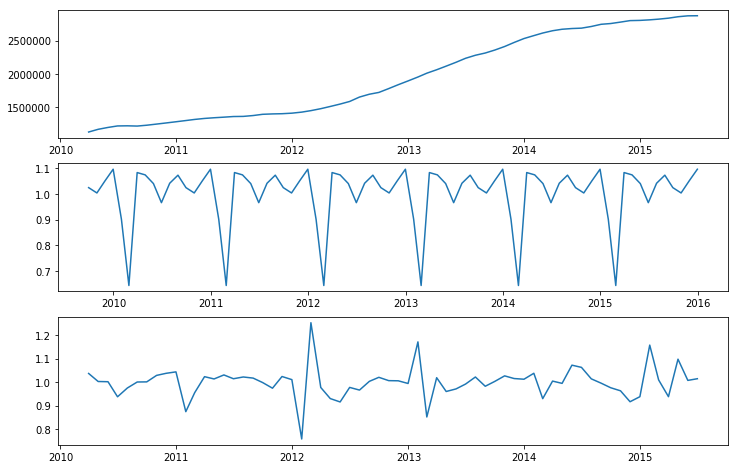

In [19]:
decomposition = seasonal_decompose(train, model="multiplicative")

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

residual = residual.dropna()
# Ljung-Box检验
# 判断其是否是高斯白噪声
r,q,p = sm.tsa.acf(residual.values, qstat=True)
dat = np.c_[range(1,41), r[1:], q, p]
table = pd.DataFrame(dat, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table.set_index('lag'))

plt.figure(figsize=(12,8))
plt.subplot(311)
plt.plot(trend)
plt.subplot(312)
plt.plot(seasonal)
plt.subplot(313)
plt.plot(residual)
plt.show()

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


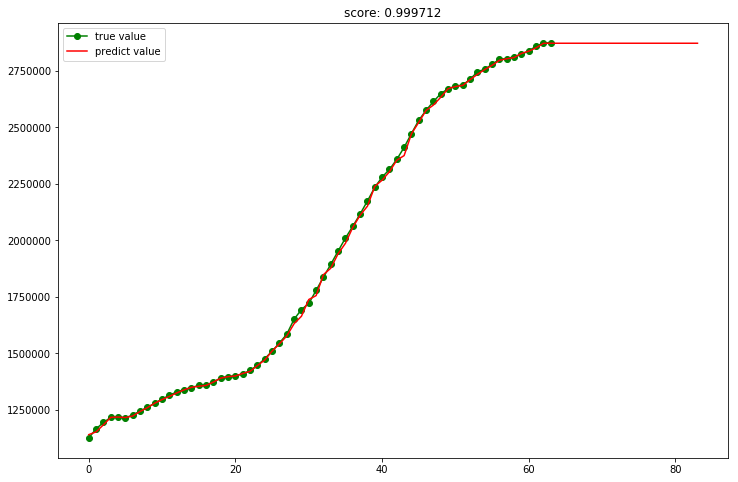

In [14]:
series = trend.dropna()
y_train = series.values.reshape(-1,1)
x_train = np.arange(0, len(y_train)).reshape(-1,1)
x_test = np.arange(0, len(y_train)+20).reshape(-1,1)
# p1=np.polyfit(x,y,4)
# yr=np.polyval(p1,x)
# predict = np.polyval(p1,xr)
def try_different_method(model):
    model.fit(x_train,y_train)
    score = model.score(x_train, y_train)
    result = model.predict(x_test)
    plt.figure(figsize=(12,8))
    plt.plot(np.arange(len(y_train)), y_train,'go-',label='true value')
    plt.plot(np.arange(len(result)),result,'r-',label='predict value')
    plt.title('score: %f'%score)
    plt.legend()
    plt.show()

####3.1决策树回归####
from sklearn import tree
model_DecisionTreeRegressor = tree.DecisionTreeRegressor()
####3.2线性回归####
from sklearn import linear_model
model_LinearRegression = linear_model.LinearRegression()
####3.3SVM回归####
from sklearn import svm
model_SVR = svm.SVR(kernel='rbf')
####3.4KNN回归####
from sklearn import neighbors
model_KNeighborsRegressor = neighbors.KNeighborsRegressor()
####3.5随机森林回归####
from sklearn import ensemble
model_RandomForestRegressor = ensemble.RandomForestRegressor(n_estimators=20)#这里使用20个决策树
####3.6Adaboost回归####
from sklearn import ensemble
model_AdaBoostRegressor = ensemble.AdaBoostRegressor(n_estimators=50)#这里使用50个决策树
####3.7GBRT回归####
from sklearn import ensemble
model_GradientBoostingRegressor = ensemble.GradientBoostingRegressor(n_estimators=100)#这里使用100个决策树
####3.8Bagging回归####
from sklearn.ensemble import BaggingRegressor
model_BaggingRegressor = BaggingRegressor()
####3.9ExtraTree极端随机树回归####
from sklearn.tree import ExtraTreeRegressor
model_ExtraTreeRegressor = ExtraTreeRegressor()
####3.10Ridge回归####
from sklearn import linear_model
model_ridge = linear_model.Ridge(alpha = .5)
####3.11Lasso回归####
model_lasso = linear_model.Lasso(alpha = .1)

try_different_method(model_BaggingRegressor)




判断线性性质

In [20]:
# p1=np.polyfit(x_train.reshape(-1,),y_train,1)
# yr=np.polyval(p1,x_train)
# predict = np.polyval(p1,x_test)
# plt.figure(figsize=(12,8))
# plt.plot(y_train)
# plt.plot(predict)
# plt.show()


def linearity(series): #返回线性拟合的R2值，1为完全拟合
    y_train = series.dropna().values.reshape(-1,1)
    x_train = np.arange(0, len(y_train)).reshape(-1,1)
    p1=np.polyfit(x_train.reshape(-1,),y_train,1)
    yr=np.polyval(p1,x_train)
    R2 = 1 - ((yr - y_train)**2).sum() / ((y_train - y_train.mean())**2).sum()
    return R2

print("R2 score on the result of linear regression: ", linearity(trend))

R2 score on the result of linear regression:  0.9564334383095483


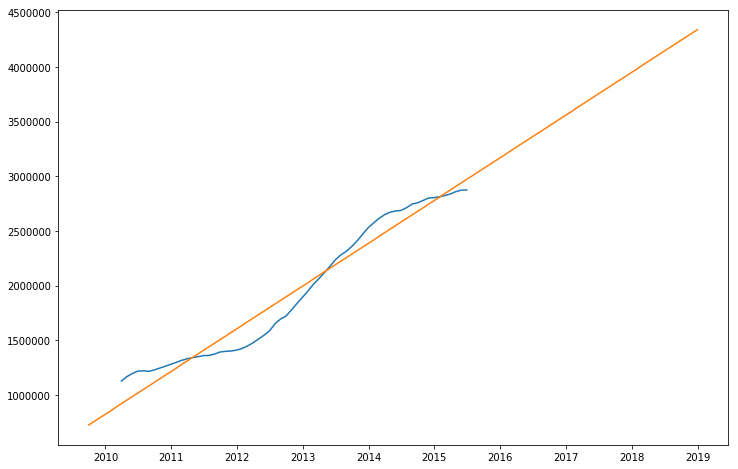

In [44]:
#pridict trend
def nonan_start(series):
    for i in range(len(series)):
        if np.isnan(series[i])==False:
            return i
    return np.nan

begin = nonan_start(trend)
end_year = '2018'
pred_length = int(end_year)-trend.index[-1].year

series = trend.dropna()
y_train = series.values.reshape(-1,1)
x_train = np.arange(0, len(y_train)).reshape(-1,1)
x_test = np.arange(-begin, len(y_train)+begin+pred_length*12).reshape(-1,1)

p1=np.polyfit(x_train.reshape(-1,),y_train,1) #可以更改多项式阶数，高阶可以拟合曲线十分精准，但是预测是往往极度发散
yr=np.polyval(p1,x_train)

predict_arr = np.polyval(p1,x_test)
idx = pd.date_range(start = trend.index[0], end = end_year+'1231', freq='M')
predict_tr = pd.Series(predict_arr.reshape(-1,), index = idx)


plt.figure(figsize=(12,8))
plt.plot(trend)
plt.plot(predict_tr)
plt.show()

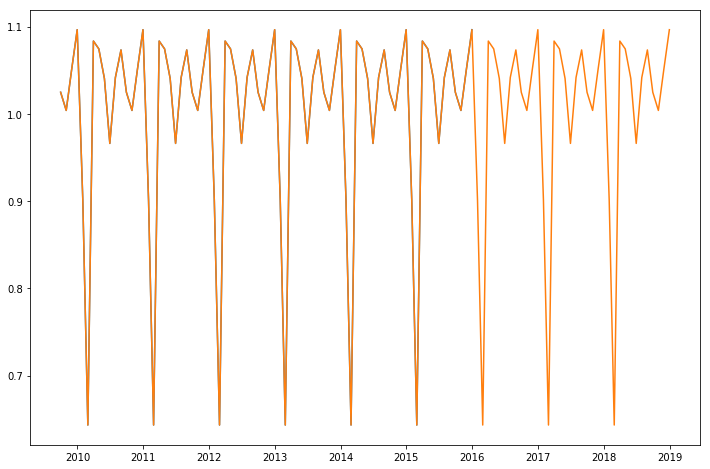

In [33]:
#predict seasonal
def getYear(series):
    cur = seasonal.index.year[0]
    while(cur<=seasonal.index.year[-1]):
        if len(seasonal[str(cur)]) == 12:
            return cur
        else:
            cur += 1
    return -1
whole_year = getYear(seasonal)
period = seasonal[str(whole_year)].values

end_year = '2018'
pred_length = int(end_year)-trend.index[-1].year
idx = pd.date_range(start = trend.index[0], end = end_year+'1231', freq='M')
res = list()
for i in range(pred_length):
    res = np.hstack((res,period))
predict = np.hstack((seasonal.values,res))
predict_se = pd.Series(predict, index = idx)

plt.figure(figsize=(12,8))
plt.plot(seasonal)
plt.plot(predict_se)
plt.show()

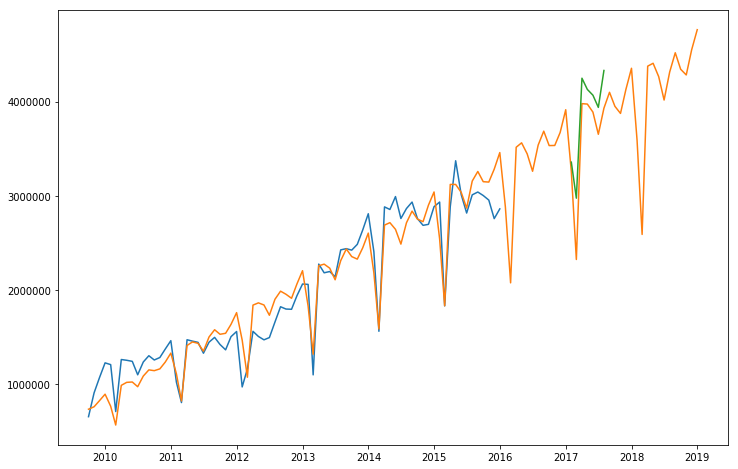

In [34]:
#add res
sigma = np.var(residual)
end_year = '2018'
pred_length = int(end_year)-trend.index[-1].year
idx = pd.date_range(start = trend.index[0], end = end_year+'1231', freq='M')
predict_re = pd.Series(sigma*np.random.randn(len(idx))+1, index = idx)

prediction = predict_tr*predict_se*predict_re

plt.figure(figsize=(12,8))
plt.plot(train)
plt.plot(prediction)
plt.plot(df_truck_2017M)
plt.show()

In [35]:
# decomposition = seasonal_decompose(prediction, model="multiplicative")

# trend = decomposition.trend
# seasonal = decomposition.seasonal
# residual = decomposition.resid


# plt.figure(figsize=(12,8))
# plt.subplot(311)
# plt.plot(trend)
# plt.subplot(312)
# plt.plot(seasonal)
# plt.subplot(313)
# plt.plot(residual)
# plt.show()

In [36]:
def score(result, target):
    error = list()
    mse = list()
    for i in range(len(result)):
        error.append(abs(result[i]-target[i])/target[i])
        mse.append(pow((result[i]-target[i]),2))
    return np.mean(error),np.sqrt(np.mean(mse))

(a,b) = score(df_truck_2017M,prediction['2017'][0:len(df_truck_2017M)])
print("偏差百分比：", a)
print("rmse：", b)

偏差百分比： 0.09183974266382997
rmse： 338709.4264597919


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in reciprocal
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


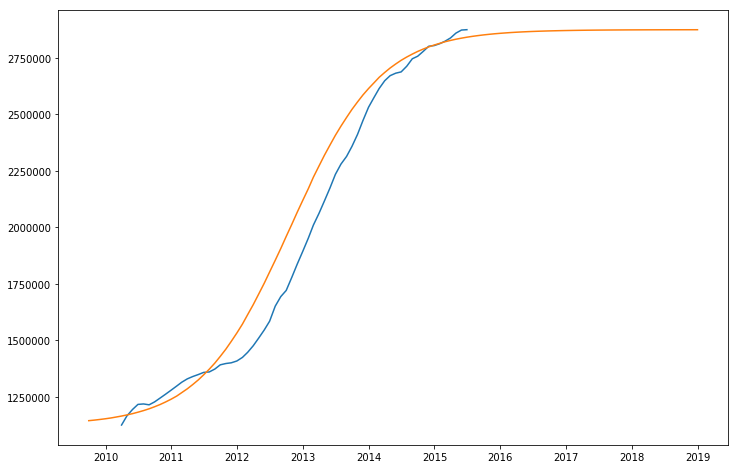

偏差百分比： 0.09183974266382997
rmse： 338709.4264597919


In [37]:
#尝试使用逻辑函数回归，偏差0.40，并不适合本例
from sklearn.preprocessing import MinMaxScaler

begin = nonan_start(trend)
end_year = '2018'
pred_length = int(end_year)-trend.index[-1].year

series = trend.dropna()
y_train = series.values.reshape(-1,1)
# x_train = np.arange(0, len(y_train)).reshape(-1,1)
x_test = np.arange(-begin, len(y_train)+begin+pred_length*12).reshape(-1,1)



# series = trend.dropna()
# y_train = series.values.reshape(-1,1)
scaler = MinMaxScaler()
scaler.fit(y_train)
y_train = scaler.transform(y_train)


y_log = np.log((y_train)**(-1)-1)
y_log = np.delete(y_log,0)
y_log = np.delete(y_log,-1)

x_train = np.arange(0, len(y_log)).reshape(-1,1)
# x_test = np.arange(0, len(y_train)).reshape(-1,1)

p1=np.polyfit(x_train.reshape(-1,), y_log, 1)
yr=np.polyval(p1,x_train)
predict_arr = np.polyval(p1,x_test)
idx = pd.date_range(start = trend.index[0], end = end_year+'1231', freq='M')
predict_tr = pd.Series(predict_arr.reshape(-1,), index = idx)

predict_tr = (np.exp(predict_tr)+1)**(-1)
predict_tr = scaler.inverse_transform(predict_tr.reshape(-1,1))
predict_tr = pd.Series(predict_tr.reshape(-1,), index = idx)


plt.figure(figsize=(12,8))
plt.plot(trend)
plt.plot(predict_tr)
plt.show()

(a,b) = score(df_truck_2017M,prediction['2017'][0:len(df_truck_2017M)])
print("偏差百分比：", a)
print("rmse：", b)

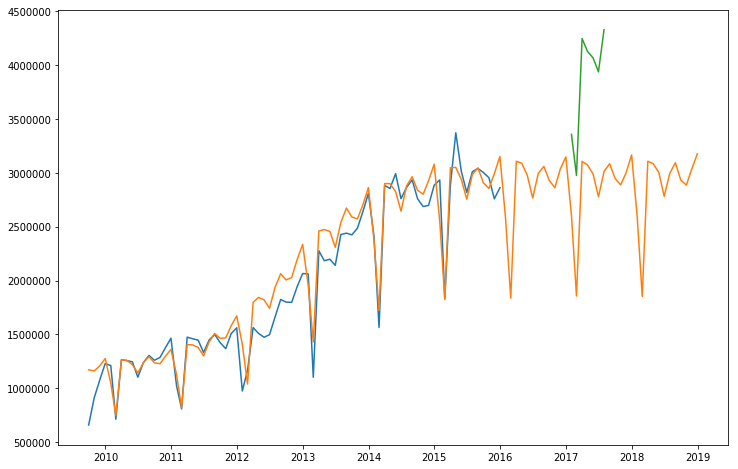

In [38]:
#综合
sigma = np.var(residual)
end_year = '2018'
pred_length = int(end_year)-trend.index[-1].year
idx = pd.date_range(start = trend.index[0], end = end_year+'1231', freq='M')
predict_re = pd.Series(sigma*np.random.randn(len(idx))+1, index = idx)

prediction = predict_tr*predict_se*predict_re

plt.figure(figsize=(12,8))
plt.plot(train)
plt.plot(prediction)
plt.plot(df_truck_2017M)
plt.show()